# Hydrological modeling with a simple LSTM network of 30 units

## Abstract
Are neural networks the future of hydrological modeling? Maybe. This simple LSTM is in many ways a poor model; yet, it performs quite good. On the small 15-year dataset included, it archives a **Nash–Sutcliffe efficiency/R2 of** **0.74** on the 3-year validation part (where 0.00 is the trivial mean prediction and 1.00 is perfect prediction). On the same validation set, my own HBV implementation, [SwiftHBV](https://github.com/jontingvold/swift-hbv), archives **0.78**. It still much left to beat HBV, especially its robustness, but perhaps a longer dataset and a new RNN architecture, without LSTM's drawbacks, would be able to.

## Introduction
There have been some papers out there that have tried to model rainfall-runoff and sometimes snow storage with LSTM neural networks. For instance Kratzert et al. (2018) who archives a median Nash–Sutcliffe efficiency/R2 of 0.65 on 250 catchments in the US, -0.03 less than a traditional SAC-SMA+SNOW17 model. The results seem good, but not jet as good as old fashion models, like SAC-SMA+SNOW17 or HBV, which also are more robust. 

This was a quick model I through together to see for myself how good these models perform compare to HBV. In difference to HBV, this model has no catchment parameters and generally no assumptions about the world. It should, therefore, be harder to fit than HBV—especially for small datasets, like the one I used. On the other hand, are they not constrained by HBV's simplistic model of the world.

#### A poor model

I many ways are LSTM networks a poor model for hydrology. LSTM was created to model more fuzzy binary problems like natural language processing. While the memory cells can have arbitrary values, the inputs/outputs to/from them are constrained to the [-1, 1] domain with `tanh` activation functions. To be able to handle rare floods, hydrological models should not constraint large inputs or outputs.

The second problem is that LSTM has forget gates and add/subtract gates. Generally, we would like to have models where water is passed around from input, to different internal (storage) cells, between (storage) cells and then to output, without water being created or lost, except for the correction of precipitation at the input and a separate evaporation output that could be monitored. 

These problems do not make LSTM inherently unusable. LSTMs are general computation machines that should theoretically be able to compute anything, given enough units. The problem is just that they might be unnecessary hard to train.

## Method

#### Model

The model is a simple LSTM with one layer and 30 units, plus one output layer with ReLU activation. 

#### Optimization

- Adam is used for optimization with a learning rate of 0.00001
- The sequence length is 30 time steps (days) and batch size 1. Thus the error is back propagated 30 time steps and parameters are updated without batching.
- The internal state is reset every epoch (12 years). It can therefore learn dependencies longer than 30 days. 
- The loss function is mean squared error on the discharge. There is no explicit optimization of the accumulated discharge.

#### Dataset

I used a short 15-years dataset from Hagabru, a discharge station in the Gaula river system, south of Trondheim (Norway). This catchment has a big area of 3059,5 km2 and no lakes to dampen responses. The first 12-years are used as training set, the last 3 years as validation set. 

## Results

#### Training experience

- Normalize inputs and outputs between 0.0–1.0 seems to have a big effect on how fast optimization converges, but not prediction performance. Since the LSTM layers outputs are between -1 to +1, the dense layer has to increase their weights. It seems to take a lot of time before these weights are fully learned. 
- Increasing the number of LSTM-units seems to have a modest effect on performance after 30 neurons on the small dataset.
- Two LSTM-layers gave the same fit on the training set and slightly worse on the validation set. It might increase a bit with a bigger dataset, but I don't think it is very beneficial with many layers for hydrological models.
- Normal SGD Nesterov with momentum seems to converge extremely poorly compared with Adam. I have no explanation for why. 
- I tried to put accumulated discharge in the loss/objective/cost function, but this just led to models that cap peaks and smoothens the discharge rate. R2 was reduced to 0.54 on the validation set.
- I tried ReLU as activation function, but convergence failed and outputs produced NaNs. Not sure why, but ReLUs are uncommon for LSTM, so it might be that ReLUs make values explode and convergence unstable.

#### Performance

###### R2/Nash-Sutcliffe efficiency
Training set: 0.82 (HBV: 0.78)  
Validation set: 0.74 (HBV: 0.78)   

*(Where 0.0 is the trivial mean prediction and 1.0 is perfect prediction.)*

The LSTM network is generally not much behind the HBV-model. It performs four percentage points, or 20% worse than the HBV-model. However, the LSTM model is less robust. HBV performs equally well on the validation set as the training set, while the LSTM model performs 8 percentage points worse.

![](results/Train-0.png)
![](results/Train-1.png)
![](results/Train-2.png)
![](results/Train-3.png)
![](results/Train-4.png)
![](results/Val-5.png)
![](results/Val-6.png)
![](results/Val-7.png)
![](results/Val-8.png)
![](results/Val-9.png)

######  Rainfall events

- It seems  to estimate the peak size after rainfall events quite well, perhaps slightly better than HBV.
- The discharge falls a bit weird. It seems to fall linearly with lots of breaks. It should fall like exponential decay, where the decay is larger for/after big rainfall events.
- It seems like the model has a maximal discharge rate. Large peaks are underestimated and simulated peaks have ca. the same value. 

###### Snowmelt

- The model struggles with spring melt when the temperature is near zero, for instance in March and April 2014, and March 2012. When the temperature is high, like in June 2012, the estimates are good. Snowmelt around zero is something all hydrological models struggle with because snowmelt is affected not only by temperature, but also wind, humidity and in-/outgoing radiation (e.g. clear nights). It still performs worse than HBV, but the HBV is configured with the elevation distribution of the catchment and the estimated temperature on different elevations, while the LSTM-network needs to learn it, so it should perform worse. 
- It seems to be able to learn to store snow, but it is hard to know how accurately it records and store snow levels. The model seems to output more water after winters with more precipitation, and it looks like the accumulated discharge is neither severely over- or underestimated during spring melt the two first years in the validation set. However, in 2014 the discharge is way too high over time.

## Discussion

- The performance looks quite good compared to the simple, poor model and short time series. It is quite amazing how well it behaves from being trained on only 4380 time steps and that it learns quite well to store snow over long periods.
- The reason it underestimates peaks is probably because of the `tanh` activation functions. It is not the biggest problem, but it probably makes LSTM unusable to estimate (rare) flood events. A different RNN architecture could perhaps solve this.
- It is hard to know how accurate the model store snow levels. However, it is probably far away from HBV. The model would likely benefit from a more constraint model when it comes to adding and subtracting water from memory cells.
- The problem that discharge rates do not smoothly decay after rainfall events, might be an artifact by how LSTM networks work. LSTM networks should be able to model exponential decay. However it requires that the cell units have values around 0.5 (so they neither are limited the tanh activation functions, or they are close to zero and produce small outputs), the activation layer needs produce outputs near 0, so the sigmoids produce output near 0.5 and decent decaying factors, and the outputs should into the forget gates on the next time step and remove the same amount of water from the cell states that was outputted. It is a lot to demand that LSTM networks should learn this accurately, and the fact that it does not look like it does might mean that LSTM networks are poor at accurately modeling snow levels, and get proper decaying outputting from storage cells.
- Even if LSTM-model had performed similarly as HBV, the HBV-model would be preferred. It is, of course, a lot more robust, and performs almost equally well on the validation set as the training set.


## Conclusion

This dataset is too small to get a decent overview of LSTMs performance. However, on this dataset it performs quite well. It is not too much behind HBV, although its predictions are a lot less robust and trustwordy compare to HBV. The LSTM model fails at some places which might indicate that the architecture is not the best, like that the  decaying after rainfall events are not very smooth and constrained peaks. It would be interesting to look at other RNN architectures that are more suitable for hydrological modeling.

#### Is it possible to create a better model?

For hydrology, we probably want an RNN network with ReLU gates and where water not lost or created. However, designing new RNN architectures is not the easiest task in the world. LSTM (and the similar GRU) has been the default architecture because it is difficult to create RNN models. LSTM was carefully designed to make training stable and avoid the vanishing gradient problem and be able to propagate errors over long time frames. I have tried to think of a better model, but probably need to think a bit more seriously, if I should have a chance. 

It would also be interesting to implement HBV, or something similar, in Tensorflow and train it with gradient descent like a neural network. As far as I can see is the only strictly undifferentiable parts in HBV min/max functions, and they are differentiable in practice. 

However, a pure HBV trained with gradient descent might be stuck in local minimas. Local minimas are usually not a problem for neural networks because they have lots of parameters. The chance that all second derivates are all positive is therefore small. HBV has only 16 parameters and is, therefore, more likely to be stuck in local minimas if it's not trained by algorithms that tackle local minimas. 

The ideal model might be therefore something between HBV and LSTM—a network based on HBV's tank model, but with more parameters, more freedom, and less linearity. The error in storage cells should also be able to flow freely back in time without degradation to be able to train long term dependencies like snow storage over the winter.

## References
- Kratzert, Frederik, Daniel Klotz, Claire Brenner, Karsten Schulz, and Mathew Herrnegger. “Rainfall–Runoff Modelling Using Long Short-Term Memory (LSTM) Networks.” Hydrology and Earth System Sciences 22, no. 11 (November 22, 2018): 6005–22. https://doi.org/10.5194/hess-22-6005-2018.

# Setup
Imports and functions

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.metrics

import plotly
import plotly.graph_objects

pd.plotting.register_matplotlib_converters()

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.__version__

# Matplotlib style sheet
plt.style.use('seaborn-pastel')
plt.style.use('jont')
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.random.set_seed(13)

In [3]:
# Data preprosessing functions

def hydrological_year(df, i):
    date = df.index[i]
    if date.month >= 9:
        return date.year
    else:
        return date.year-1

In [4]:
# Tensorflow time series preprocessing functions

def multivariate_data(x, y, sequence_length, start_index=0, end_index=None, step=1):
    
    start_index = start_index + sequence_length
    if end_index is None:
        end_index = len(x) - sequence_length

    number_of_sequences = int((end_index - start_index)/step)
    number_of_features = len(x[0])

    new_x = np.zeros(shape=[number_of_sequences, sequence_length, number_of_features])
    new_y = np.zeros(shape=[number_of_sequences, sequence_length])

    for i in range(number_of_sequences):
        i_dataset = start_index + i*sequence_length
        
        slice_d = slice(i_dataset-sequence_length, i_dataset)
        if x[slice_d].shape == new_x[i].shape:
            new_x[i] = x[slice_d]
        if y[slice_d].shape == new_y[i].shape:
            new_y[i] = y[slice_d]

    return new_x, new_y

In [5]:
# Get estimated values from model

def predict(model, x_test, y_test, SEQUENCE_LENGTH, INPUT_d):
    model.reset_states()
    y_test_hat = y_test.copy()

    n_windows = int(len(x_test)/SEQUENCE_LENGTH)
    for i in range(n_windows):
        x_test_sequence = x_test.iloc[i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]
        x_test_sequence = x_test_sequence.values.reshape([1, SEQUENCE_LENGTH, INPUT_d])
        y_test_hat_sequence = model.predict(x_test_sequence).flatten()

        y_test_hat[i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH] = y_test_hat_sequence
    return y_test_hat

In [6]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [7]:
# Result plot functions

def plot_data_with_temp_precip(x, y, y_hat, title="", init_timesteps=0):
    plt.rcParams["axes.spines.top"] = True
    plt.rcParams["axes.spines.right"] = True
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
    
    year_from = y.index.year[0]
    year_to = y.index.year[-1]
    r2 = sklearn.metrics.r2_score(y.values[init_timesteps:], y_hat.values[init_timesteps:])
    
    if title:
        title = title + ", "
    if year_to == year_from+1:
        title = title + "%i/%i (R2: %.2f)" % (year_from, year_to, r2)
    else:
        title = title + "%i–%i (R2: %.2f)" % (year_from, year_to, r2)
    
    ax1 = axes[0]
    ax1.plot(y.index, y, label="Observed", linestyle="-")
    ax1.plot(y_hat.index, y_hat, label="Simulated", linestyle="-")
    ax1.set_xlabel("")
    ax1.set_ylabel("Discharge (m3/s)")
    ax1.set_title(title)
    ax1.set_xlim(y.index[0], y.index[-1])
    ax1.set_ylim(ax1.get_ylim()[0], 1.3*ax1.get_ylim()[1])

    colors = getattr(getattr(pd.plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=4)
    
    # Nedbør
    precipitation = x[x.columns[0]]
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    ax2.bar(precipitation.index, precipitation, label="Precipitation (mm)", color=colors[2], width=0.8)
    ax2.set_ylabel("Precipitation (mm)")
    ax2.invert_yaxis()
    ax2.set_ylim(2.0*ax2.get_ylim()[0], ax2.get_ylim()[1])
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left", framealpha=0.5)
    
    # Temperatur
    temp = x[x.columns[1]]
    ax3 = axes[1]
    #ax3.plot(temp.index, temp, color=colors[3])
    temp.plot(ax=ax3, color=colors[3])
    ax3.set_xlabel("")
    ax3.set_ylabel("Temperature (°C)")
    ax3.axhline(0.0, color="black", linestyle="dotted")
    
    fig.tight_layout()
    
    return fig


def plot_data(y_val, y_val_hat, title=""):
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.right"] = False
    ax = pd.DataFrame({
        "Observed": y_val,
        "Simulated": y_val_hat
    }).plot(style=["-", "-"], figsize=(15, 5));
    ax.set_xlabel("")
    ax.set_ylabel("Discharge (m3/s)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.get_figure().tight_layout()
    
    return ax
    
def plot_accumulated(y_val, y_val_hat, title=""):
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.right"] = False
    
    max_observed = sum(y_val)
    
    ax = pd.DataFrame({
        "Observed": y_val.cumsum() / max_observed,
        "Simulated": y_val_hat.cumsum()  / max_observed
    }).plot(style=["-", "-"], figsize=(15, 3));
    ax.set_xlabel("")
    ax.set_ylabel("Accumulated discharge\n1.0=total observed")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.get_figure().tight_layout()
    
    return ax

## Preprocess dataset

- Min/max temperature the same. Drop min.
- Divide dataset into hydrological years (sep–aug)
- Set 2000–2011 as training set and 2011–2014 as validation set
- Normalize inputs and outputs to be between 0.0–1.0

In [8]:
# Load dataset

filename = "data/Hagabru_input.txt"
df = pd.read_csv(filename, sep="\t")
df = df[1:] # Drop first row
df.index = pd.to_datetime(df["Dato"] + " " + df["Time"], format='%d.%m.%Y %H:%M:%S')

df = df.drop(columns=["Dato", "Time"])

# min/max temp is equal in this dataset, so drop one and rename other
df = df.rename(columns={"T_maxC_738moh": "T_C_738moh"}).drop(columns=["T_minC_738moh"])
df = df.astype("float")

# Add hydrological years
df["hydrological_year_from"] = [hydrological_year(df, i) for i in range(len(df))]
df["hydrological_year_to"] = [hydrological_year(df, i)+1 for i in range(len(df))]
df

,P_mm_738moh,T_C_738moh,Q_Hagabru,hydrological_year_from,hydrological_year_to
2000-04-01,1.42,-1.77,26.79,1999,2000
2000-04-02,0.15,-6.05,24.96,1999,2000
2000-04-03,1.96,-6.08,22.11,1999,2000
2000-04-04,0.80,-7.14,19.44,1999,2000
2000-04-05,1.53,-7.99,17.62,1999,2000
...,...,...,...,...,...
2015-12-27,1.94,-9.26,14.25,2015,2016
2015-12-28,0.00,-11.26,11.91,2015,2016
2015-12-29,0.00,-7.13,10.87,2015,2016
2015-12-30,0.01,-3.12,11.91,2015,2016


In [9]:
train_from_hyd_year = 2000
train_to_hyd_year = 2010
test_from_hyd_year = 2011
test_to_hyd_year = 2013

X_columns = ["P_mm_738moh", "T_C_738moh"]
Y_columns = "Q_Hagabru"

df_not_feb_29 = df[~((df.index.month == 2) & (df.index.day == 29))]
df_train = df_not_feb_29[(train_from_hyd_year <= df_not_feb_29["hydrological_year_from"]) & (df_not_feb_29["hydrological_year_from"] <= train_to_hyd_year)]
df_test = df_not_feb_29[(test_from_hyd_year <= df_not_feb_29["hydrological_year_from"]) & (df_not_feb_29["hydrological_year_from"] <= test_to_hyd_year)]

X_train, Y_train = df_train[X_columns], df_train[Y_columns]
X_test, Y_test = df_test[X_columns], df_test[Y_columns]

In [10]:
Y_max = df[Y_columns].max()
print("Y max: %.2f" % (Y_max,))

def normalizeY(Y):
    return  Y/Y_max

def denormalizeY(normalized_Y):
    return normalized_Y * Y_max

Y_train = normalizeY(Y_train)
Y_test = normalizeY(Y_test)

Y max: 959.68


In [11]:
X_max = df[X_columns].max()
print("X max:\n %s" % (X_max,))

def normalizeX(X):
    return  X/X_max

def denormalizeX(normalized_X):
    return normalized_X * X_max

X_train = normalizeX(X_train)
X_test = normalizeX(X_test)

X max:
 P_mm_738moh    44.45
T_C_738moh     20.92
dtype: float64


In [12]:
# Variance
print("Variance training set: %.5f" % Y_train.var())
print("Variance validation set: %.5f" % Y_test.var())

Variance training set: 0.00957
Variance validation set: 0.00871


### Prepair dataset for Tensorflow
Divide dataset into destinct sequences of 30 days/timesteps, but only reset state of LSTM after each epoch (full time series).
Batch size = 1

In [13]:
SEQUENCE_LENGTH = 30 # days
BATCH_SIZE = 1
STEP = 30

INPUT_d = 2
OUTPUT_d = 1

x_train, y_train = multivariate_data(
    X_train.values, Y_train.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)
x_val, y_val = multivariate_data(
    X_test.values, Y_test.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

print(x_train.shape, y_train.shape)
print(train_data)

(131, 30, 2) (131, 30)
<BatchDataset shapes: ((None, 30, 2), (None, 30)), types: (tf.float64, tf.float64)>


In [14]:
SEQUENCE_LENGTH = 365 # days
BATCH_SIZE = 1
STEP = 365

INPUT_d = 2
OUTPUT_d = 1

x_train, y_train = multivariate_data(
    X_train.values, Y_train.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)
x_val, y_val = multivariate_data(
    X_test.values, Y_test.values, SEQUENCE_LENGTH, start_index=0, end_index=None, step=STEP)

train_data2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
val_data2 = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

print(x_train.shape, y_train.shape)
print(train_data)

(9, 365, 2) (9, 365)
<BatchDataset shapes: ((None, 30, 2), (None, 30)), types: (tf.float64, tf.float64)>


## Model

A simple LSTM model with 1 layer and 30 units, and one additional ReLU layer to combine units. The LSTM output is  limited to the -1.0–1.0 domain.

Optmized with Adam.

In [15]:
klayers = tf.keras.layers

model = tf.keras.models.Sequential()
model.add(klayers.LSTM(30, return_sequences=True, stateful=True,
                         input_shape=(None, INPUT_d,), 
                         batch_input_shape=(BATCH_SIZE, None, INPUT_d)))
model.add(klayers.Dense(OUTPUT_d, activation="relu"))

model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='mse', metrics=['mae'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 30)             3960      
_________________________________________________________________
dense (Dense)                (1, None, 1)              31        
Total params: 3,991
Trainable params: 3,991
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
#model.load_weights('3 - LSTM statefull')

In [17]:
# Define callbacks

class ResetStateBetweenEpochs(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        self.model.reset_states()

class ResetStateBetweenBatches(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        self.model.reset_states()

# Stop after 20 epochs with no improvement
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

Training with a sequence size of 30 days seems to have the best effect. One year sequences overfits the data. Short sequences are slower to train. The overfitting seems to be serious if the val_loss haven't improve in 50 epochs. Less than 20 and training terminates too early.

In [18]:
#model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[ResetStateBetweenBatches(), earlyStopping])
#model.fit(train_data2, validation_data=val_data2, epochs=10, callbacks=[ResetStateBetweenEpochs(), earlyStopping])

history = model.fit(
    train_data, 
    validation_data=val_data, 
    epochs=2000, 
    callbacks=[ResetStateBetweenEpochs(), earlyStopping]
)

Epoch 1/2000
131/131 [==============================] - 11s 83ms/step - loss: 0.0090 - mae: 0.0496 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/2000
131/131 [==============================] - 3s 21ms/step - loss: 0.0080 - mae: 0.0505 - val_loss: 0.0068 - val_mae: 0.0445
Epoch 3/2000
131/131 [==============================] - 3s 22ms/step - loss: 0.0078 - mae: 0.0518 - val_loss: 0.0067 - val_mae: 0.0460
Epoch 4/2000
131/131 [==============================] - 3s 21ms/step - loss: 0.0077 - mae: 0.0525 - val_loss: 0.0067 - val_mae: 0.0470
Epoch 5/2000
131/131 [==============================] - 3s 20ms/step - loss: 0.0076 - mae: 0.0529 - val_loss: 0.0067 - val_mae: 0.0476
Epoch 6/2000
131/131 [==============================] - 3s 24ms/step - loss: 0.0076 - mae: 0.0531 - val_loss: 0.0066 - val_mae: 0.0480
Epoch 7/2000
131/131 [==============================] - 3s 21ms/step - loss: 0.0075 - mae: 0.0532 - val_loss: 0.0066 - val_mae: 0.0483
Epoch 8/2000
131/131 [========================

131/131 [==============================] - 3s 26ms/step - loss: 0.0028 - mae: 0.0300 - val_loss: 0.0028 - val_mae: 0.0331
Epoch 122/2000
131/131 [==============================] - 3s 26ms/step - loss: 0.0028 - mae: 0.0300 - val_loss: 0.0028 - val_mae: 0.0331
Epoch 123/2000
131/131 [==============================] - 3s 26ms/step - loss: 0.0028 - mae: 0.0300 - val_loss: 0.0028 - val_mae: 0.0331
Epoch 124/2000
131/131 [==============================] - 3s 25ms/step - loss: 0.0028 - mae: 0.0299 - val_loss: 0.0027 - val_mae: 0.0330
Epoch 125/2000
131/131 [==============================] - 4s 29ms/step - loss: 0.0028 - mae: 0.0299 - val_loss: 0.0027 - val_mae: 0.0330
Epoch 126/2000
131/131 [==============================] - 3s 26ms/step - loss: 0.0028 - mae: 0.0299 - val_loss: 0.0027 - val_mae: 0.0330
Epoch 127/2000
131/131 [==============================] - 3s 26ms/step - loss: 0.0028 - mae: 0.0299 - val_loss: 0.0027 - val_mae: 0.0329
Epoch 128/2000
131/131 [==============================] 

Epoch 181/2000
131/131 [==============================] - 4s 27ms/step - loss: 0.0025 - mae: 0.0286 - val_loss: 0.0025 - val_mae: 0.0318
Epoch 182/2000
131/131 [==============================] - 4s 27ms/step - loss: 0.0025 - mae: 0.0286 - val_loss: 0.0025 - val_mae: 0.0318
Epoch 183/2000
131/131 [==============================] - 4s 27ms/step - loss: 0.0025 - mae: 0.0286 - val_loss: 0.0025 - val_mae: 0.0318
Epoch 184/2000
131/131 [==============================] - 3s 24ms/step - loss: 0.0025 - mae: 0.0285 - val_loss: 0.0025 - val_mae: 0.0318
Epoch 185/2000
131/131 [==============================] - 3s 27ms/step - loss: 0.0025 - mae: 0.0285 - val_loss: 0.0025 - val_mae: 0.0317
Epoch 186/2000
131/131 [==============================] - 3s 23ms/step - loss: 0.0025 - mae: 0.0285 - val_loss: 0.0025 - val_mae: 0.0317
Epoch 187/2000
131/131 [==============================] - 3s 22ms/step - loss: 0.0025 - mae: 0.0285 - val_loss: 0.0025 - val_mae: 0.0317
Epoch 188/2000
131/131 [=================

Epoch 241/2000
131/131 [==============================] - 3s 20ms/step - loss: 0.0024 - mae: 0.0277 - val_loss: 0.0024 - val_mae: 0.0311
Epoch 242/2000
131/131 [==============================] - 3s 20ms/step - loss: 0.0024 - mae: 0.0277 - val_loss: 0.0024 - val_mae: 0.0311
Epoch 243/2000
131/131 [==============================] - 3s 20ms/step - loss: 0.0024 - mae: 0.0277 - val_loss: 0.0024 - val_mae: 0.0311
Epoch 244/2000
131/131 [==============================] - 3s 20ms/step - loss: 0.0023 - mae: 0.0277 - val_loss: 0.0024 - val_mae: 0.0311
Epoch 245/2000
131/131 [==============================] - 2s 19ms/step - loss: 0.0023 - mae: 0.0277 - val_loss: 0.0024 - val_mae: 0.0311
Epoch 246/2000
131/131 [==============================] - 3s 21ms/step - loss: 0.0023 - mae: 0.0276 - val_loss: 0.0024 - val_mae: 0.0311
Epoch 247/2000
131/131 [==============================] - 3s 20ms/step - loss: 0.0023 - mae: 0.0276 - val_loss: 0.0024 - val_mae: 0.0310
Epoch 248/2000
131/131 [=================

Epoch 301/2000
131/131 [==============================] - 3s 19ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 302/2000
131/131 [==============================] - 2s 18ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 303/2000
131/131 [==============================] - 2s 18ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 304/2000
131/131 [==============================] - 2s 18ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 305/2000
131/131 [==============================] - 2s 18ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 306/2000
131/131 [==============================] - 2s 18ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 307/2000
131/131 [==============================] - 2s 19ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 308/2000
131/131 [=================

Epoch 361/2000
131/131 [==============================] - 3s 23ms/step - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0308
Epoch 362/2000
131/131 [==============================] - 3s 23ms/step - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 363/2000
131/131 [==============================] - 3s 22ms/step - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 364/2000
131/131 [==============================] - 3s 22ms/step - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 365/2000
131/131 [==============================] - 3s 23ms/step - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 366/2000
131/131 [==============================] - 3s 22ms/step - loss: 0.0022 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 367/2000
131/131 [==============================] - 3s 20ms/step - loss: 0.0021 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0307
Epoch 368/2000
131/131 [=================

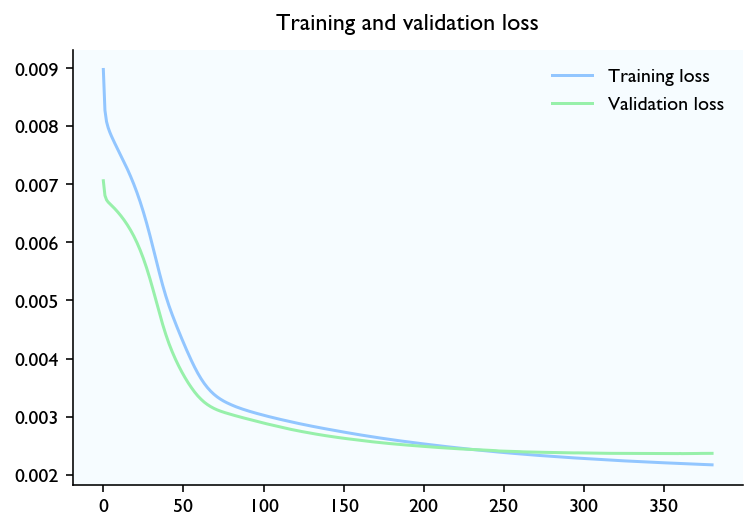

In [19]:
plot_train_history(history, 'Training and validation loss')

In [20]:
#model.save_weights('3 - LSTM statefull')

## Results
### Training set

R2: 0.83 of 1.0
MAE: 23.75 m3/s


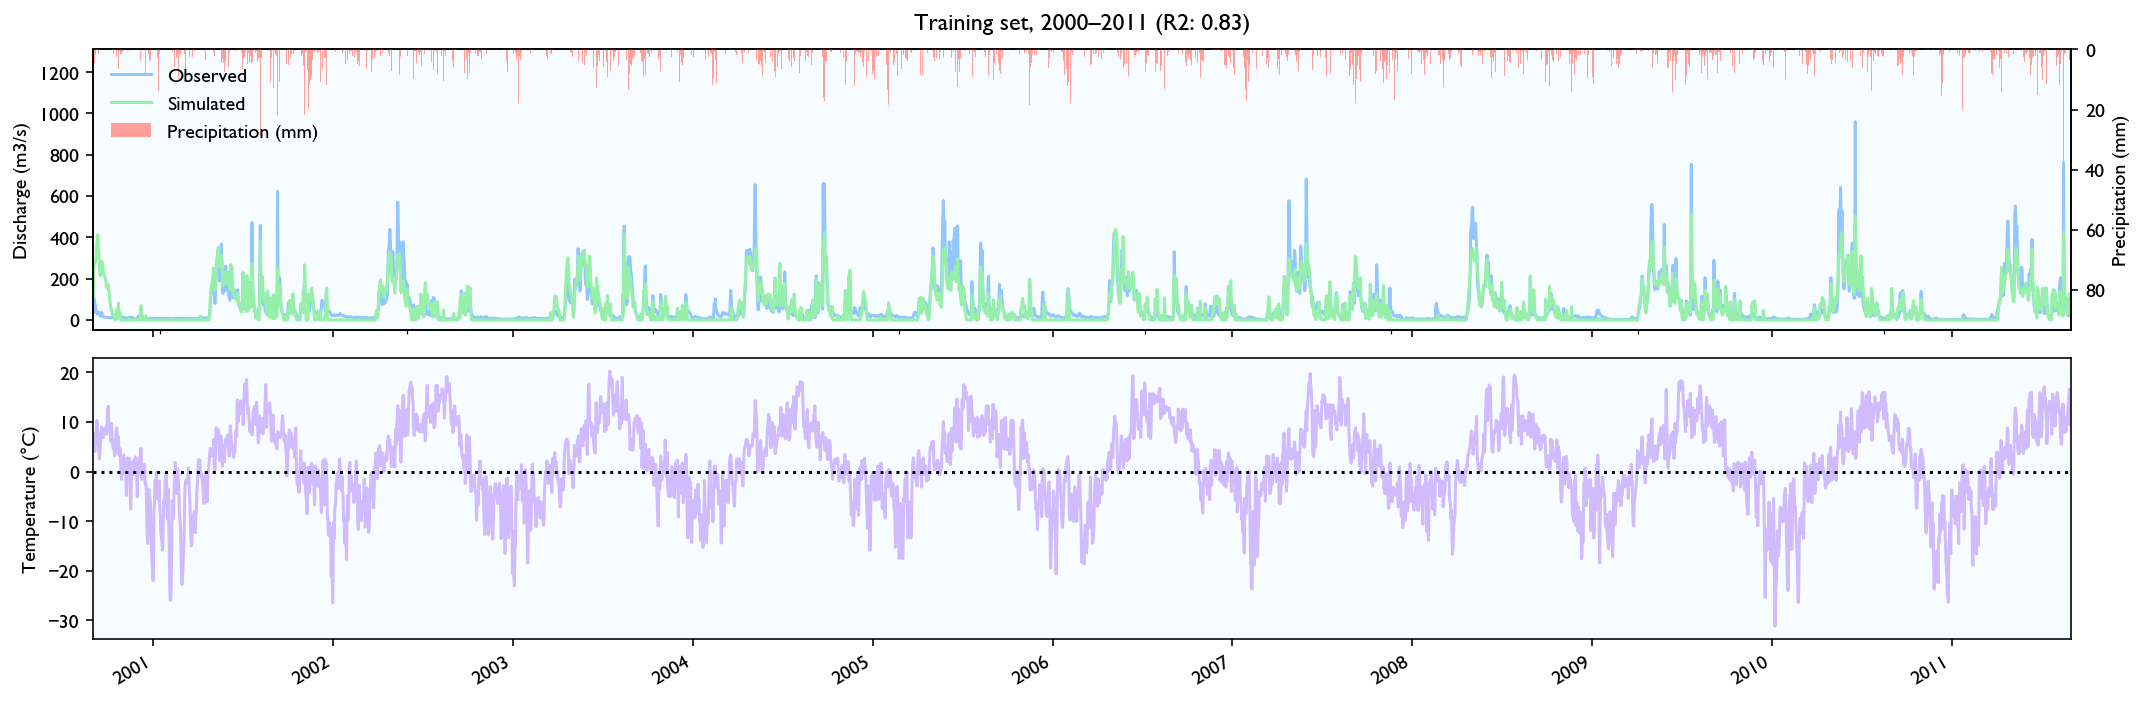

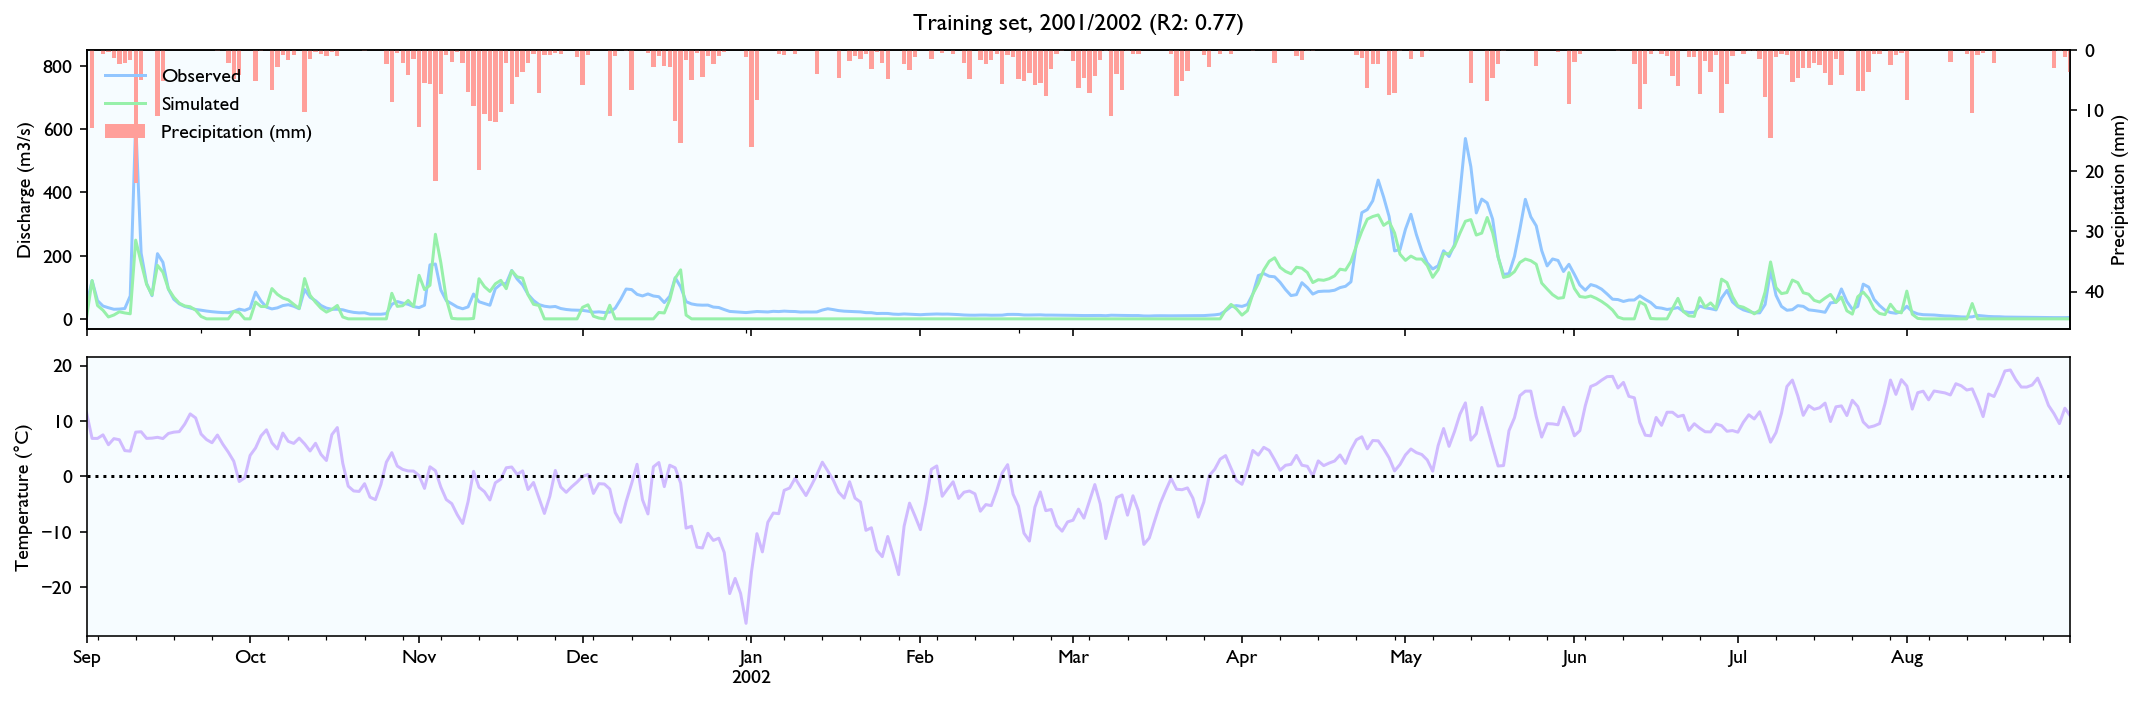

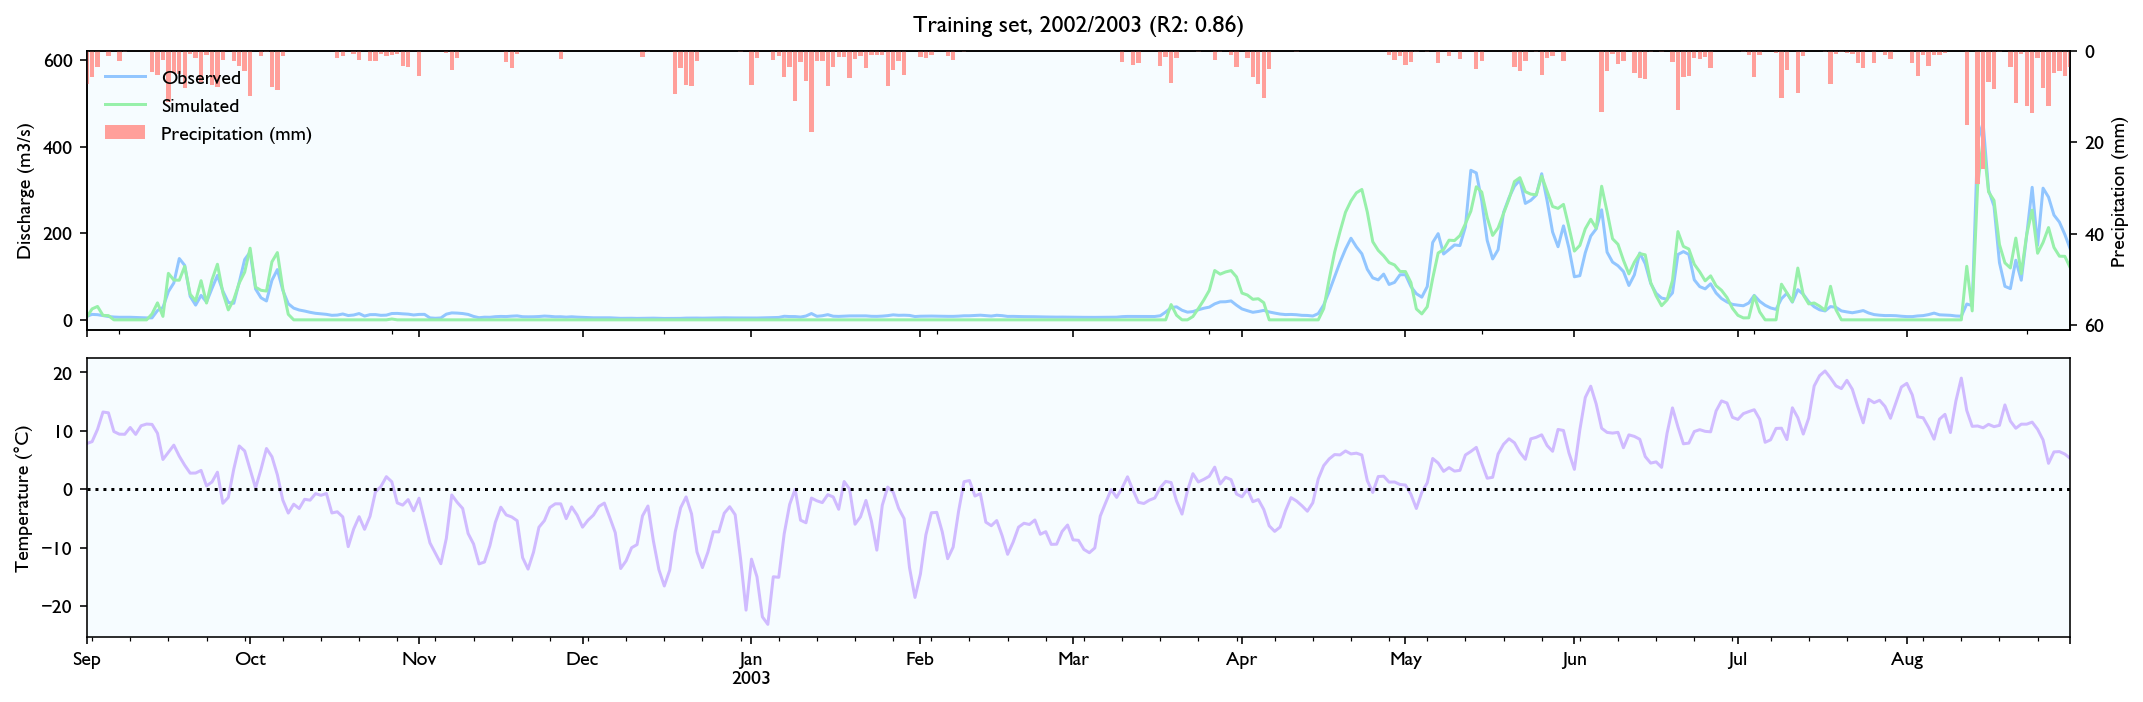

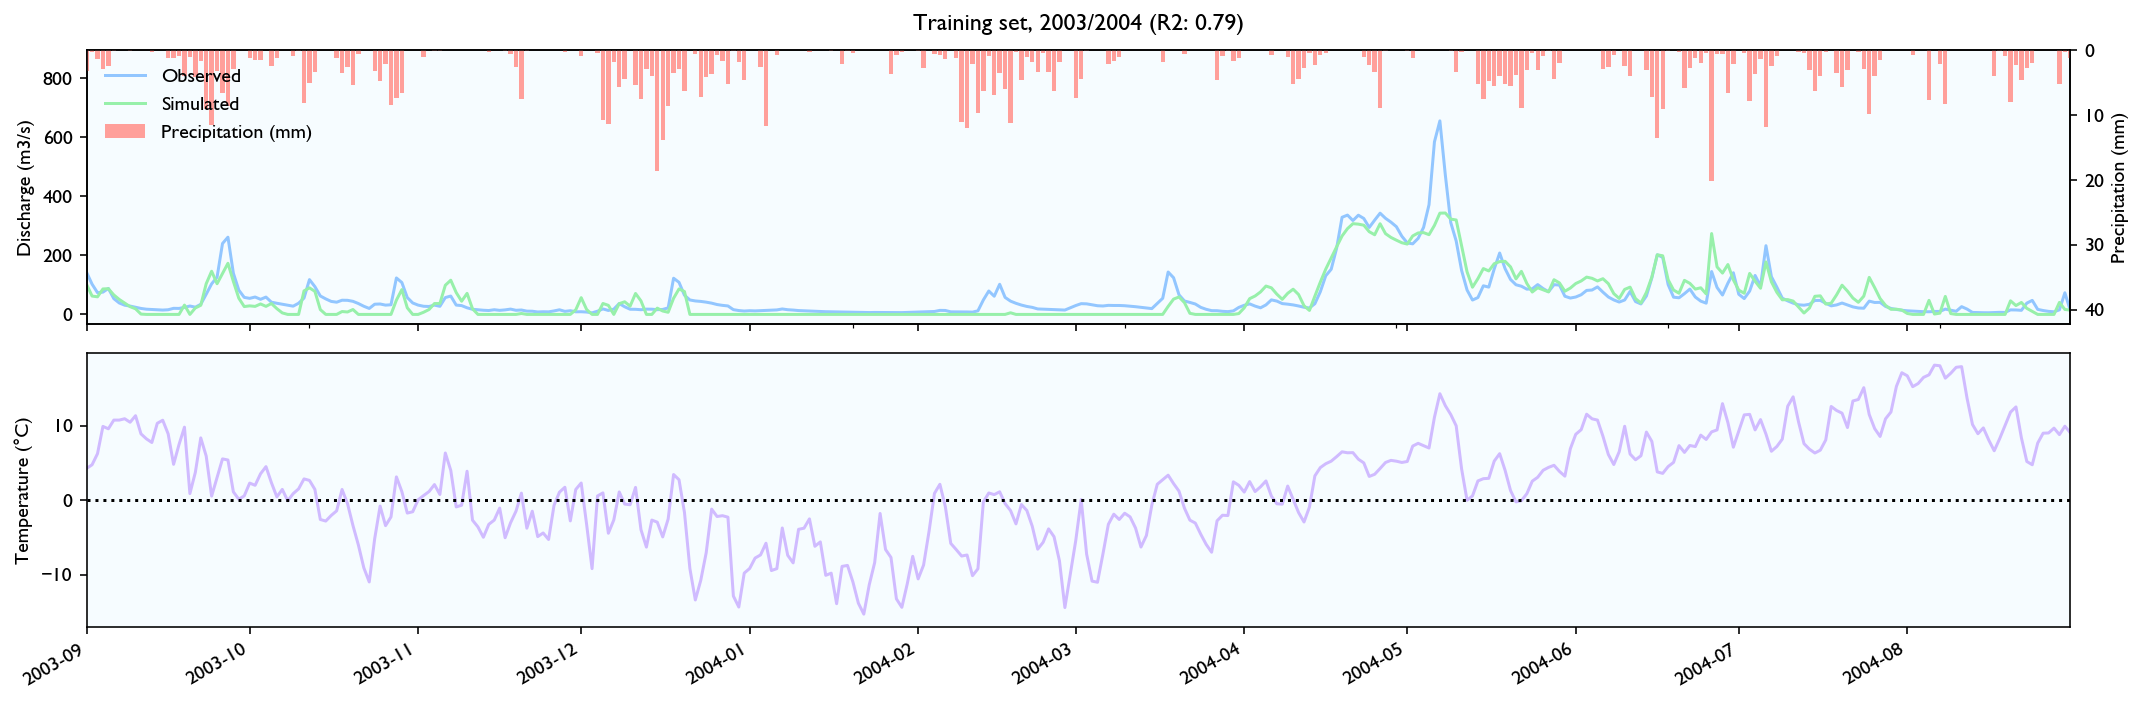

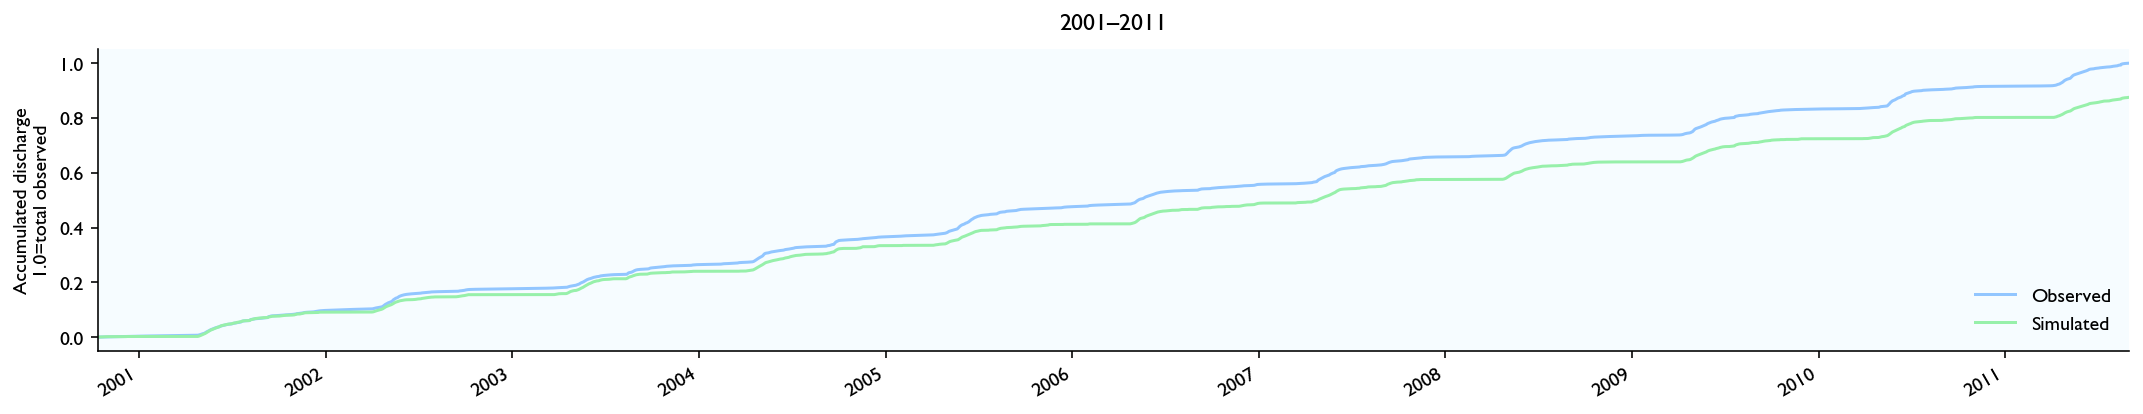

In [23]:
x = df_train[X_columns]
y = df_train[Y_columns]
x_norm = normalizeX(x)
y_norm = normalizeY(y)
y_hat_norm = predict(model, x_norm, y_norm, SEQUENCE_LENGTH, INPUT_d)
y_hat = denormalizeY(y_hat_norm)

init_timesteps=40
print("R2: %.2f of 1.0" % sklearn.metrics.r2_score(y.values[init_timesteps:], y_hat.values[init_timesteps:]))
print("MAE: %.2f m3/s" % sklearn.metrics.mean_absolute_error(y.values[init_timesteps:], y_hat.values[init_timesteps:]))

plot_data_with_temp_precip(x, y, y_hat, title="Training set", init_timesteps=init_timesteps);

for year in range(2001,2004):
    s = df_train.hydrological_year_from == year
    if year==2001:
        init_timesteps=40
    else:
        init_timesteps=0
    plot_data_with_temp_precip(x[s], y[s], y_hat[s], title="Training set", init_timesteps=init_timesteps);

init_timesteps=40
plot_accumulated(y[init_timesteps:], y_hat[init_timesteps:], title="%i–%i" % (2001, 2011));

### Validation set

R2: 0.74 of 1.0
MAE: 29.23 m3/s


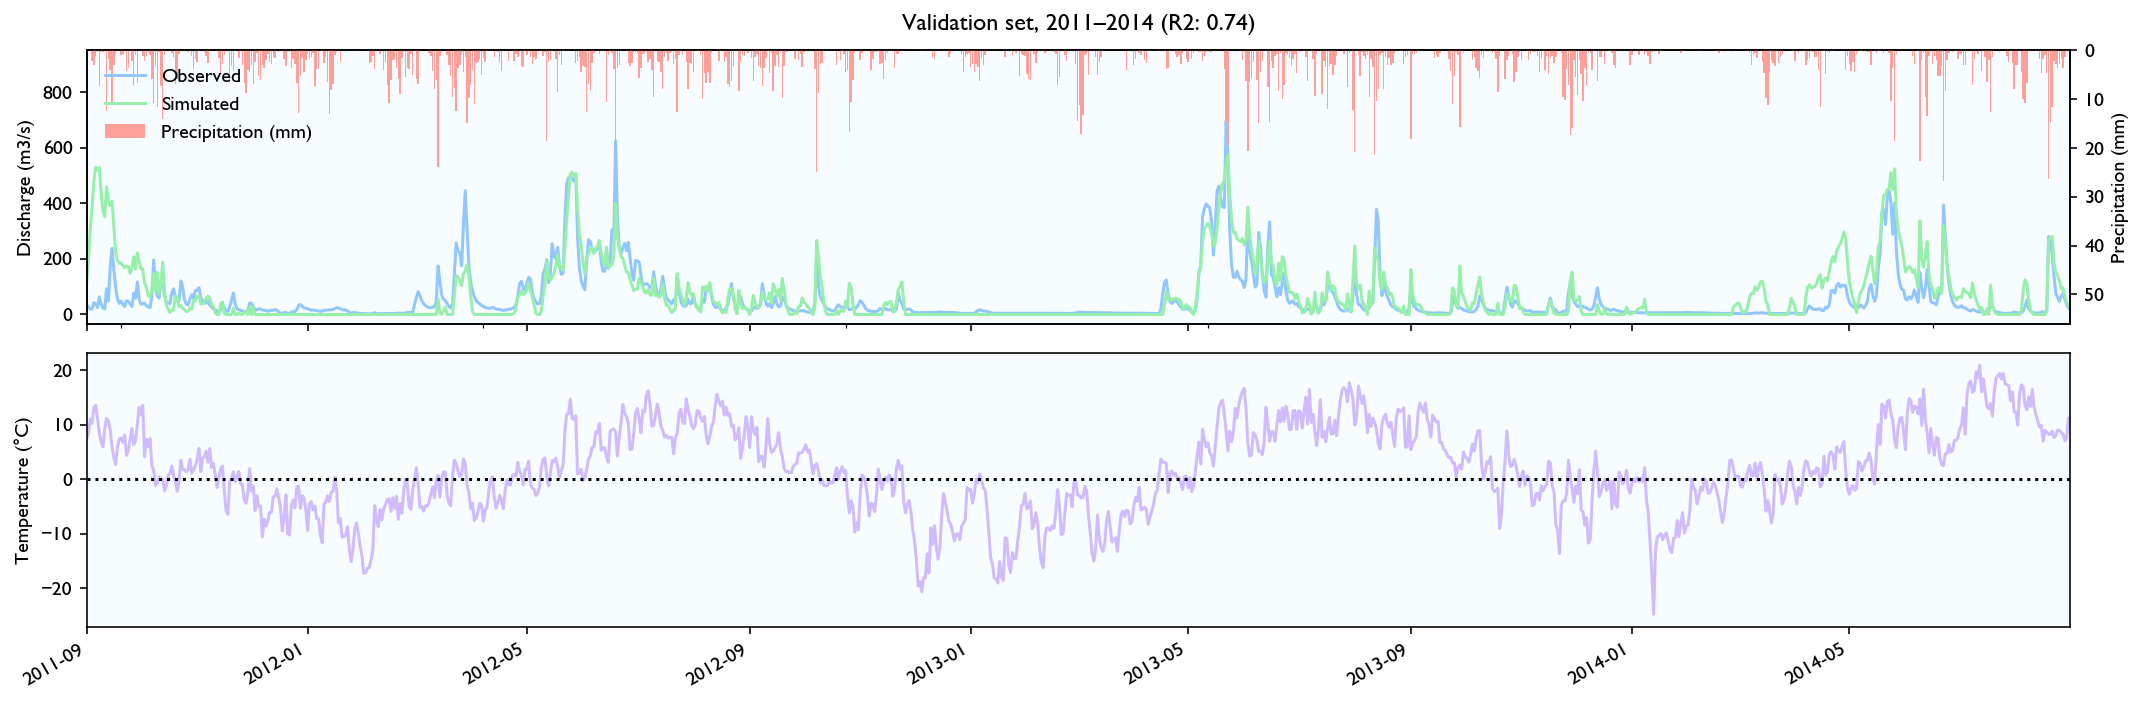

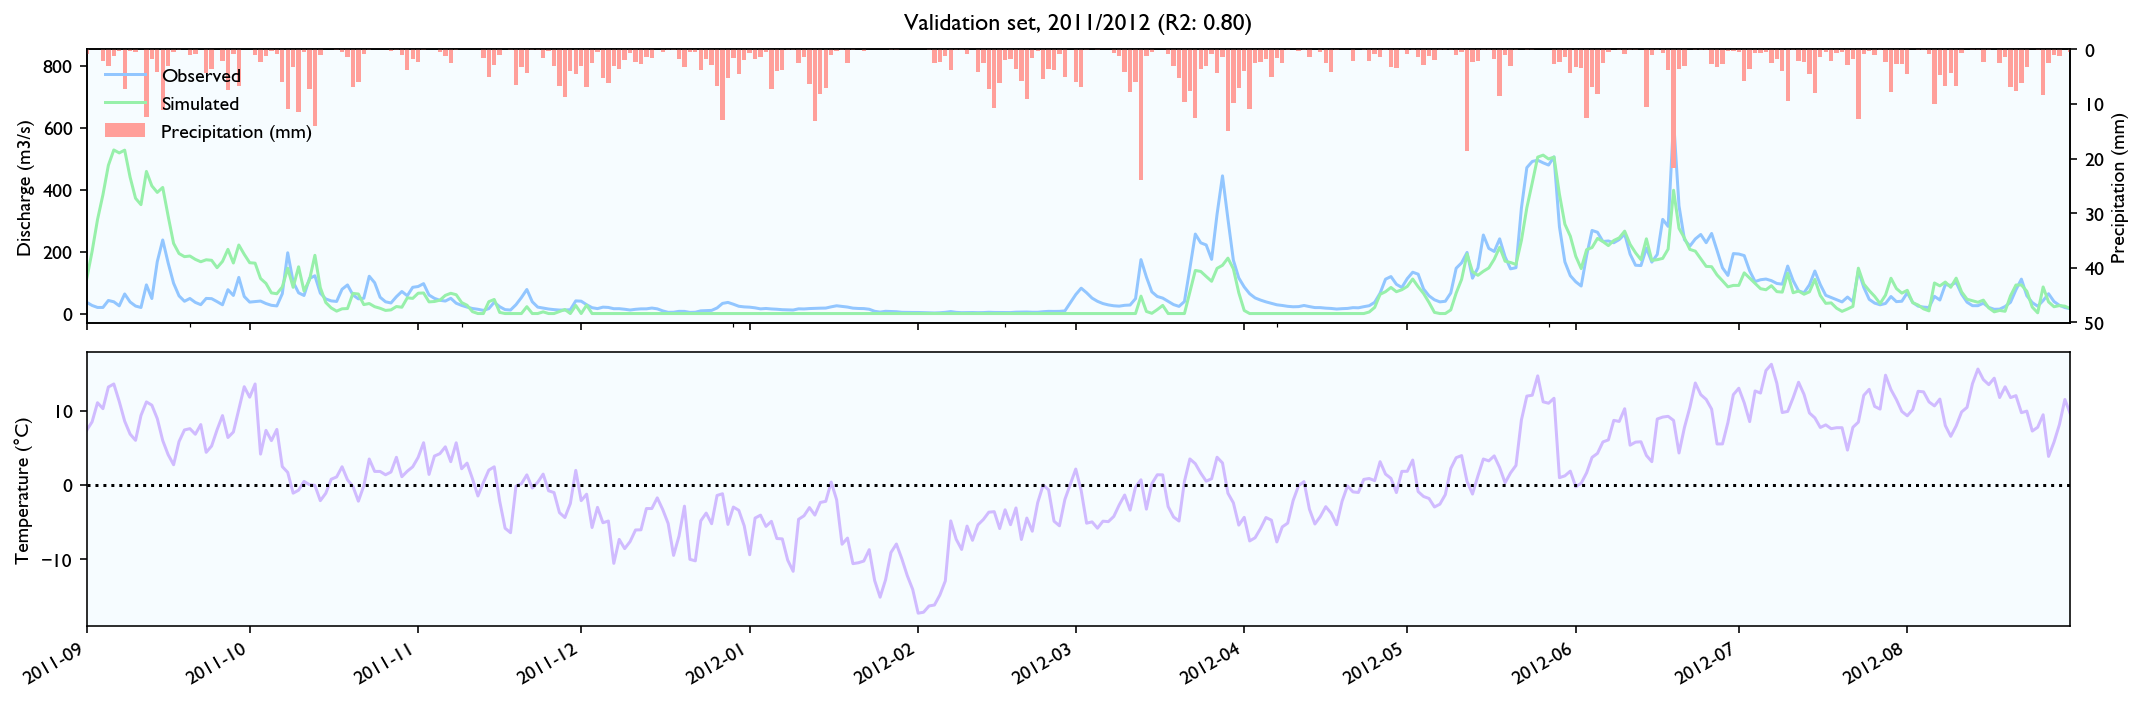

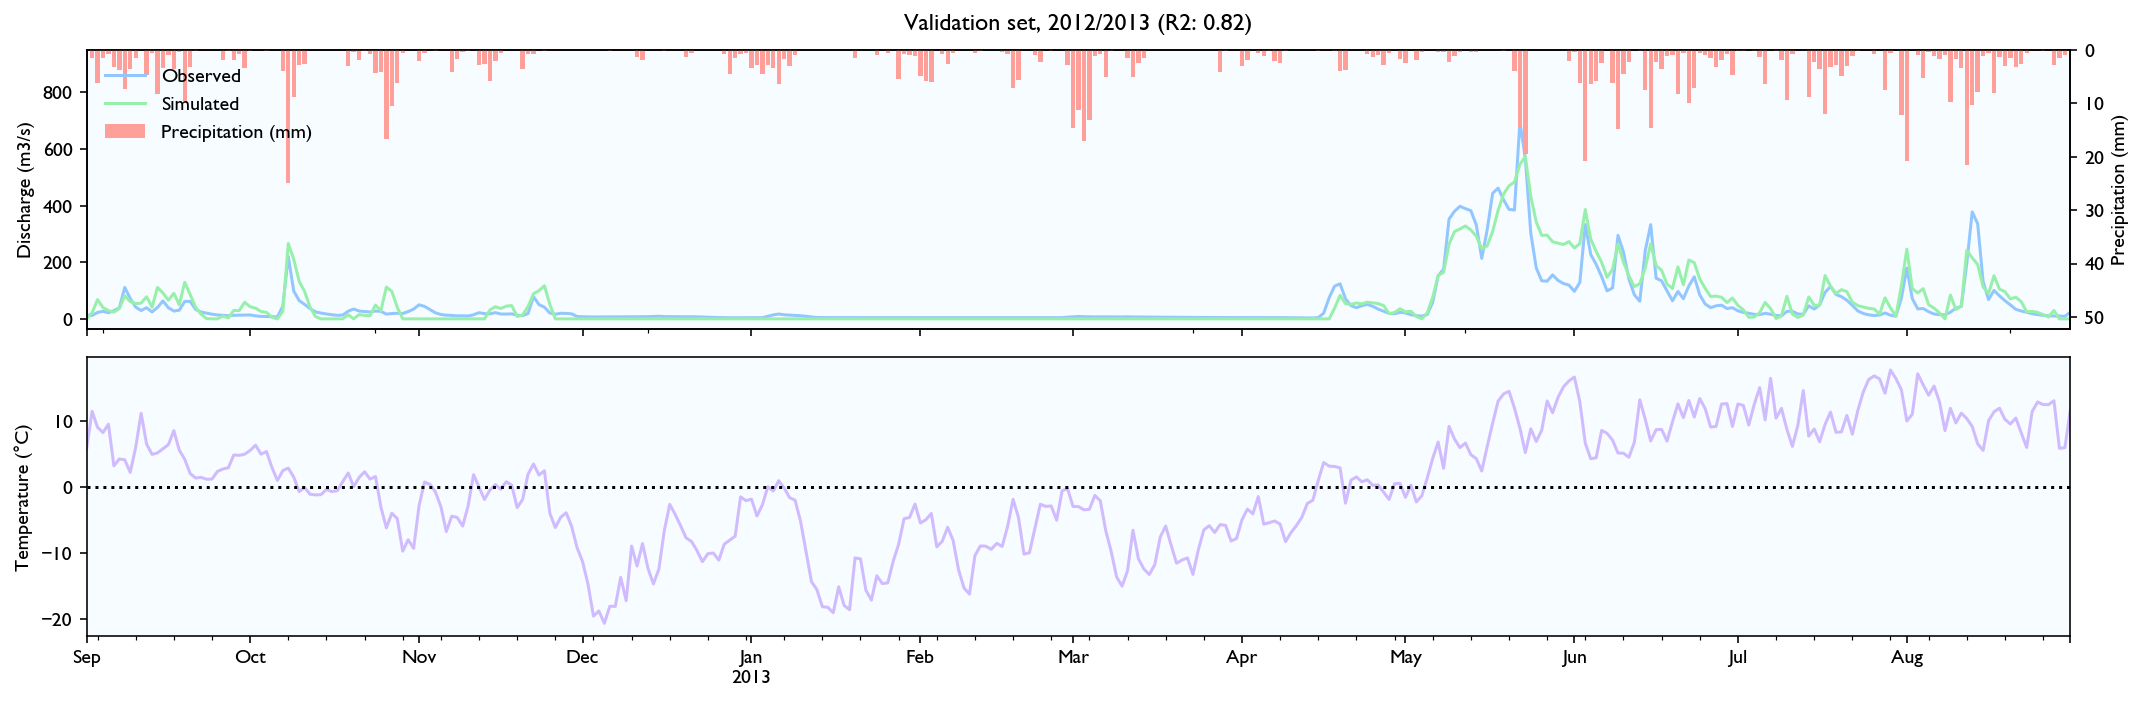

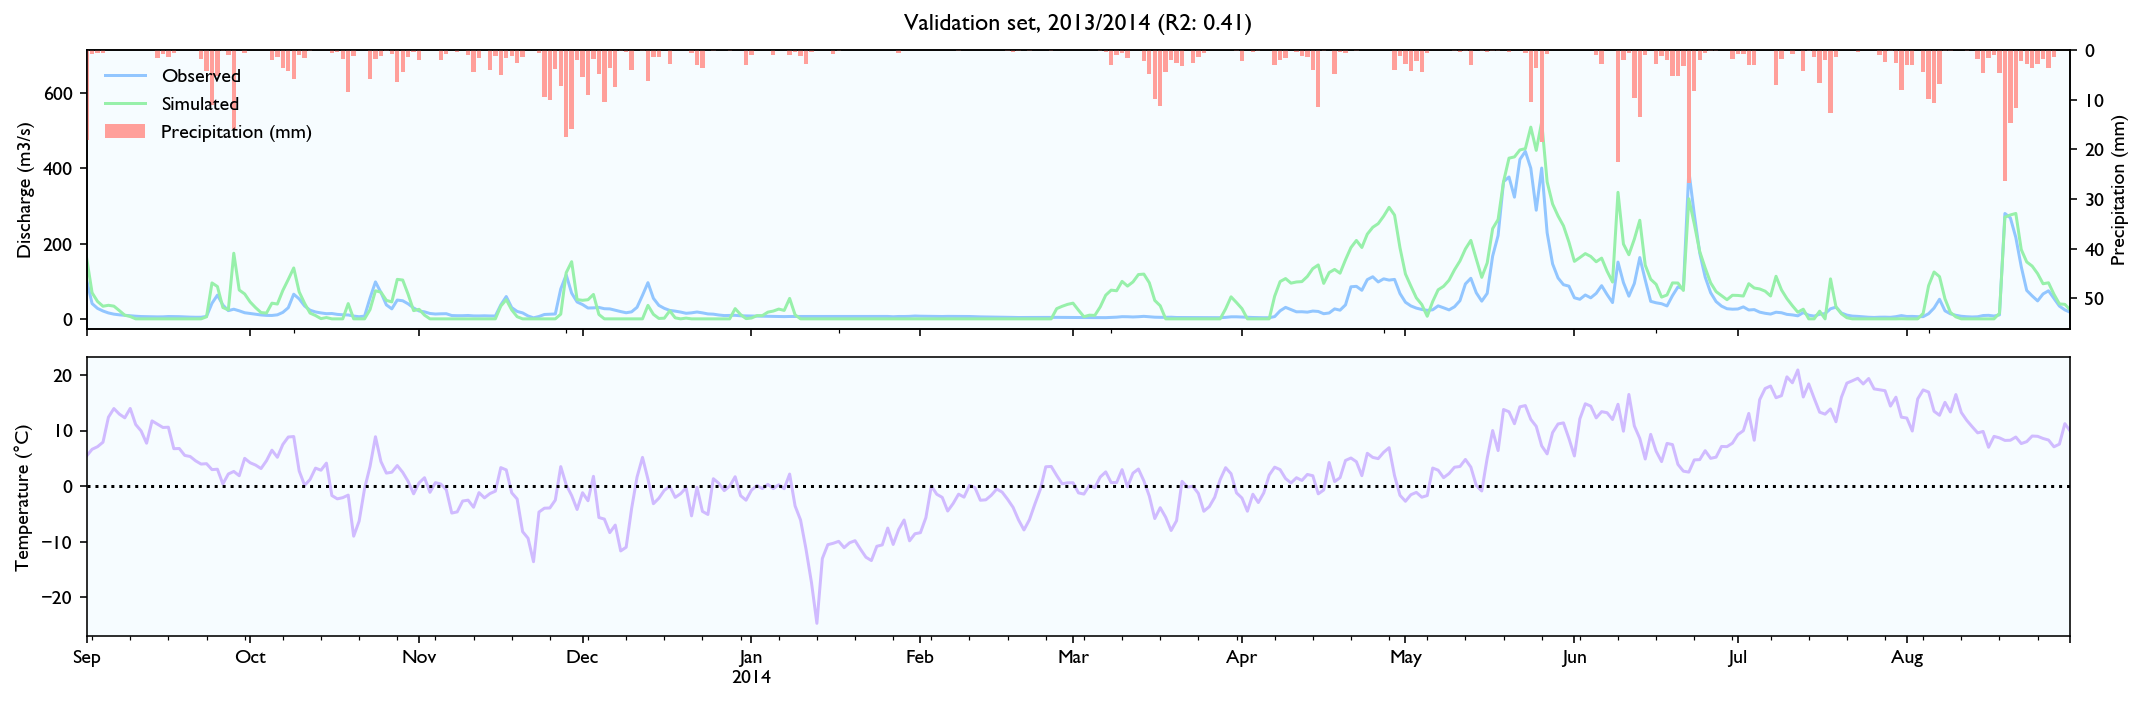

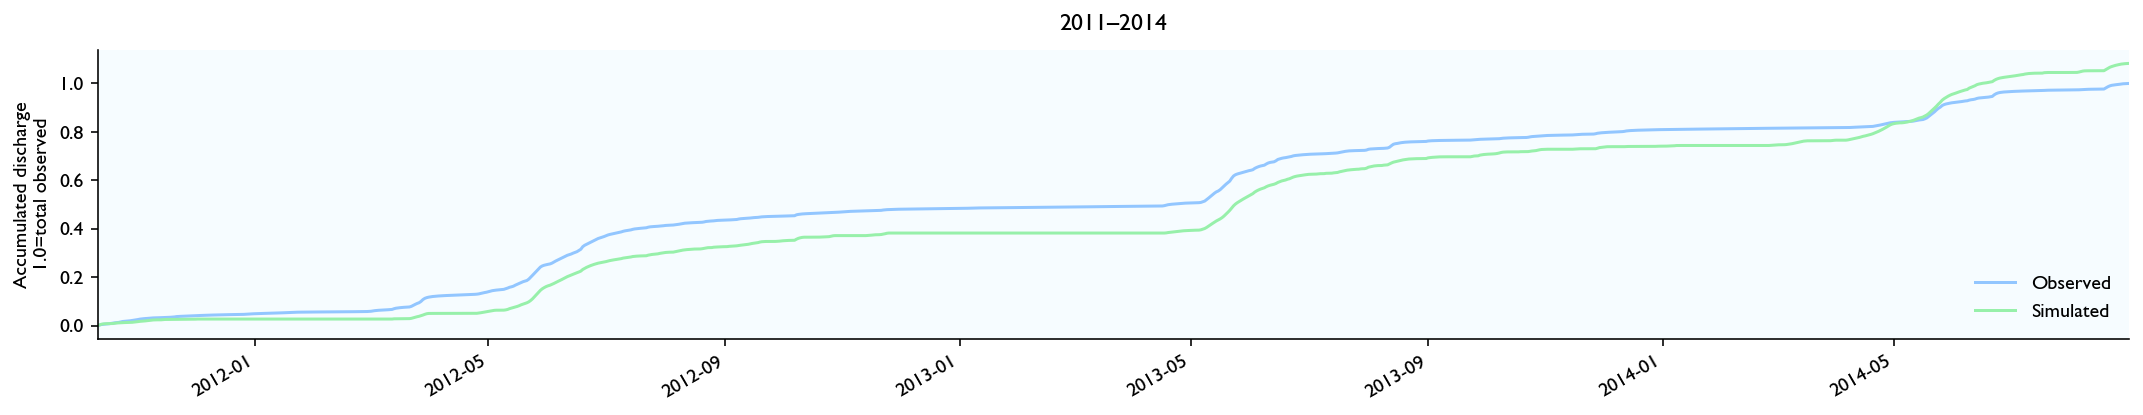

In [26]:
x = df_test[X_columns]
y = df_test[Y_columns]
x_norm = normalizeX(x)
y_norm = normalizeY(y)
y_hat_norm = predict(model, x_norm, y_norm, SEQUENCE_LENGTH, INPUT_d)
y_hat = denormalizeY(y_hat_norm)

init_timesteps=40
print("R2: %.2f of 1.0" % sklearn.metrics.r2_score(y.values[init_timesteps:], y_hat.values[init_timesteps:]))
print("MAE: %.2f m3/s" % sklearn.metrics.mean_absolute_error(y.values[init_timesteps:], y_hat.values[init_timesteps:]))

plot_data_with_temp_precip(x, y, y_hat, title="Validation set", init_timesteps=init_timesteps);

for year in range(2011, 2014):
    s = df_test.hydrological_year_from == year
    if year==2011:
        init_timesteps=40
    else:
        init_timesteps=0
    plot_data_with_temp_precip(x[s], y[s], y_hat[s], title="Validation set", init_timesteps=init_timesteps);
    
init_timesteps=40
plot_accumulated(y[init_timesteps:], y_hat[init_timesteps:], title="%i–%i" % (2011, 2014));

## TODO
- Should measure 10 times and calcualte mean and std performance
- Implement new RNN architecture